# Module and file

In [4]:
# Module and file
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np, math, scipy.stats as ss
from tqdm import tqdm

data = pd.read_csv("./suicide.csv")

# Data overview

In [117]:
# Data description
dataDesc = []
for x in data.columns:
    dataDesc.append([
        x,
        data[x].dtypes,
        data[x].isnull().sum(),
        round((((data[x].isnull().sum()) / (len(data))) * 100), 2),
        len(data[x].unique()),
        data[x].drop_duplicates().sample(2).values
    ])

print("Variables description :")
display(pd.DataFrame(data = dataDesc, columns = [
    "Columns Name",
    "Data Type",
    "NULL",
    "NULL Percentage",
    "Unique",
    "Unique Samples"
]))

Variables description :


,Columns Name,Data Type,NULL,NULL Percentage,Unique,Unique Samples
0,country,object,0,0.00,101,"[Slovakia, Malta]"
1,year,int64,0,0.00,32,"[1988, 1987]"
2,sex,object,0,0.00,2,"[male, female]"
3,age,object,0,0.00,6,"[75+ years, 55-74 years]"
4,suicides_no,int64,0,0.00,2084,"[93, 685]"
5,population,int64,0,0.00,25564,"[52333, 769273]"
6,suicides/100k pop,float64,0,0.00,5298,"[56.05, 27.28]"
7,country-year,object,0,0.00,2321,"[Slovenia2010, Colombia1992]"
8,HDI for year,float64,19456,69.94,306,"[0.725, 0.73]"
9,gdp_for_year ($),object,0,0.00,2321,"[97,724,004,252, 13,972,676,841]"


We found 3 things from the description above:
- _gdp_for_year ($)_ is actually an int variable, but has a string data type which caused by the comma within each values. Thus, we must convert it to int.
- We don't need _country_year_ variable because it's already represented by _country_ and _year_ variables.
- There are 19.456 missing values in _HDI for year_ variable. We shall fill it with certain technique to avoid information leakage. But first, we must check its significance since it covers almost 70% of our observations.

In [118]:
# Converting gdp_for_year ($) and dropping country_year
data = data.rename(columns = {
    " gdp_for_year ($) " : "gdp_for_year",
    "gdp_per_capita ($)" : "gdp_per_capita"
    }).drop("country-year", 1)

data["gdp_for_year"] = data["gdp_for_year"].apply(lambda x : int(x.replace(",", "")))

In [119]:
# Missing values
missing = data[data["HDI for year"].isna()]
print("Number of countries which have missing values in 'HDI for year' variable : ", len(missing["country"].unique()), " out of ", len(data["country"].unique()), " countries")
print("Number of years which have missing values : ", len(missing["year"].unique()), " out of ", len(data["year"].unique()), " years of observation")
print("Country which has no missing values across all years : ", data[~(data["country"].isin(missing["country"].unique()))]["country"].unique()[0])

Number of countries which have missing values in 'HDI for year' variable :  100  out of  101  countries
Number of years which have missing values :  32  out of  32  years of observation
Country which has no missing values across all years :  Bosnia and Herzegovina


Almost all countries in the data given have missing values in _HDI for year_ variable. The only one country with complete data is Bosnia and Herzegovina. We also can see that the missing values spread along all years of observation. Therefore, this variable is not significant anymore and dropping it will most likely costs us nothing.

In [120]:
# Dropping HDI_for_year
data.drop("HDI for year", 1, inplace = True)

**Checking anomaly**

The observations is time based, which is year. So, to determine anomalies we must consider _year_ and also _country_ as the determinant features.

We know that the year range is 32 years (1985 - 2016). But, is that applied to all countries?

In [121]:
# Checking if there's country with total of unique years below 32
temp = []
for country in data["country"].unique():
    if len(data[data["country"] == country]["year"].unique()) != 32:
        temp.append(country)

print("Number of countries with total years below 32 : ", len(temp))
print("\nCountries with complete years :")

for x in data[~(data["country"].isin(temp))]["country"].unique():
    print("-" + x)

Number of countries with total years below 32 :  97

Countries with complete years :
-Austria
-Iceland
-Mauritius
-Netherlands


We know that our dat aset isn't as complete as it seen. There are only 4 countries which have complete records across 1985 to 2016. Because of this fact, we **can't perform time - based holistic analysis** to all countries. Further manipulation must be considered. We can't drop certain years which some countries don't have because year is a **time series** data, which is a continuous observations. If we cut some of it, we can't show or analyze its pattern (growth or drops) with suicides rate because of inconsistent records.

To handle this, our best way is to just include years which all countries have.

In [122]:
# Defining inclusive years
temp = []
for x in data["year"].unique():
    for c in data["country"].unique():
        if len(data[(data["country"] == c) & (data["year"] == x)]) == 0:
            temp.append(x)

print("Number of years with at least one missing country : ", len(set(temp)))

Number of years with at least one missing country :  32


**This means there's not even a single year with no missing country**. Every single year has a minimum of 1 country which doesn't have a single record of it. As a result, we can't analyze this variable in regards to suicides rate. Incomplete records could lead to **data misinterpretation and misinformation**. Thus, we're going to interpolate each missing values, rather than count the mean of previous year's (Noor et al., 2007). Before we do that, let's take a look for another anomalies in other variables.

**Reference:**
- Noor, Norazian Mohamed et al. 2007. *Comparison Of Linear Interpolation Methid And Mean Method To Replace The Missing Values In Enviromental Data Set*. Penang: International Conference on Sustainable Materials (ICoSM). Accessed on February, 4th 2021 through https://www.researchgate.net/publication/271978892_Comparison_of_Linear_Interpolation_Method_and_Mean_Method_to_Replace_the_Missing_Values_in_Environmental_Data_Set.

In [123]:
# Checking if there's country within a year which has only 1 sex observation
temp = []
for y in data["year"].unique():
    for c in data["country"].unique():
        if len(data[(data["year"] == y) & (data["country"] == c)]["sex"].unique()) == 1:
            temp.append({c : y})
        
print("Country within a year which has only 1 sex observation : ", len(temp))

Country within a year which has only 1 sex observation :  0


There's no anomaly in sex variable.

In [124]:
# Checking if there's country within a year which has incomplete age observations
temp = []
for y in data["year"].unique():
    for c in data["country"].unique():
        if 0 < len(data[(data["year"] == y) & (data["country"] == c)]["age"].unique()) < 6:
            temp.append({c : y})
        
print("Country within a year which has incomplete age observations :")
for x in temp:
    for k, v in x.items():
        print(f"- {k} in {v}")

Country within a year which has incomplete age observations :
- Armenia in 2016
- Austria in 2016
- Croatia in 2016
- Cyprus in 2016
- Czech Republic in 2016
- Grenada in 2016
- Hungary in 2016
- Iceland in 2016
- Lithuania in 2016
- Mauritius in 2016
- Mongolia in 2016
- Netherlands in 2016
- Qatar in 2016
- Romania in 2016
- Sweden in 2016
- Thailand in 2016


There are 16 countries within a year which don't have complete age observations and all of them took place in 2016.

In [125]:
# Checking if there's country within a year which has incomplete generation observations
temp, temp_ = [], []
for y in data["year"].unique():
    for c in data["country"].unique():
        if 0 < len(data[(data["year"] == y) & (data["country"] == c)]["generation"].unique()) < 6:
            temp.append(c)
            temp_.append(y)
        
print("Number of unique countries which has incomplete generations observations :", len(set(temp)))
print("Number of unique years which has incomplete generations observations :", len(set(temp_)))

Number of unique countries which has incomplete generations observations : 101
Number of unique years which has incomplete generations observations : 32


Turns out not all countries and years have complete generations observations. **However, this is normal**. Once again, the data set is **time based** observation. It means a 15-24 years old person in 1987 will be labeled as Generation X, meanwhile the person in the same age range will be labeled as Millenials in 2010 observation. This results in imbalanced generation where older observations are having more older generations label and newer observations will have less. Therefore this "anomaly" shall not be worried or manipulated.

To deal with age missing values problem, we must construct our understanding under **two assumptions**:
- There're **indeed** no groups with certain age range or generations in the observed population.
- Those groups are **actually exist**, but not included in the data set for some **technical issues**.

Each of the assumptions has equal possibility. However if we choose option number 1 as our "legal standing" it would seem not fair because from our data, absence of suicide incident in certain groups of age is **indicated as 0 rather than not being included as an observation**. So, option number 2 in this case seems more acceptable. This option states that the data set **doesn't represent the actual condition** because of human or system error. We would ended up in misconclusion if we don't include the rest of the missing age groups. To handle this, as stated before, we will interpolate the values.

The interpolation process will be applied to two conditions:
- If a country doesn't have records in certain year.
- If a country within a year doesn't have complete age observations.

In [126]:
# Using linear interpolation to fill the missing values
for y in data["year"].unique():
    for c in data["country"].unique():
        deter, new = data[(data["country"] == c) & (data["year"] == y)], pd.DataFrame()
        if len(deter) == 0:
            try:
                for s in ["male", "female"]:
                    for a in data["age"].unique():
                        temp = pd.DataFrame(
                            columns = [x for x in data.columns],
                            data = [[
                                c, y, s, a, np.nan, np.nan, np.nan, np.nan, np.nan,
                                data[(data["year"] == y) & (data["age"] == a)]["generation"].unique()[0]
                            ]]
                        )

                        new = pd.concat([new, temp])

                data = pd.concat([data, new])
        
            except:  
                temp = pd.DataFrame(columns = [x for x in data.columns],
                            data = [[c, y, s, a, np.nan, np.nan, np.nan, np.nan, np.nan, "Generation Z"]])

                new = pd.concat([new, temp])
                data = pd.concat([data, new])
            
        elif len(deter["age"].unique()) != 6:
            age = data["age"].unique()
            remaining = age[np.isin(age, deter["age"].unique()) == False]
            for x in remaining:
                try:
                    for s in ["male", "female"]:
                        temp = pd.DataFrame(
                            columns = [x for x in data.columns],
                            data = [[
                                c, y, s, x, np.nan, np.nan, np.nan, np.nan, np.nan,
                                data[(data["year"] == y) & (data["age"] == x)]["generation"].unique()[0]
                            ]]
                        )

                        new = pd.concat([new, temp])

                    data = pd.concat([data, new])
                
                except:
                    temp = pd.DataFrame(columns = [x for x in data.columns],
                            data = [[c, y, s, a, np.nan, np.nan, np.nan, np.nan, np.nan, "Generation Z"]])

                    new = pd.concat([new, temp])
                    data = pd.concat([data, new])

data.reset_index(inplace = True)
data.drop("index", 1, inplace = True)
for nan in tqdm(data[data.isna().any(axis = 1)].index):
    res = data[(data["country"] == data.loc[nan, "country"]) &
         (data["sex"] == data.loc[nan, "sex"]) &
         (data["age"] == data.loc[nan, "age"])].sort_values("year").interpolate("linear").loc[nan].values
    
    data.loc[nan] = res

100%|████████████████████████████████████████████████████████████████████████████| 10958/10958 [02:10<00:00, 84.01it/s]


**NOTE**

_Except_ block in code above is for handling error which occured because there're no group of 5-14 years in 2016 for certain countries. **We then drop this year** because assigning unknown future value means predicting (time series analysis). Forecasting itself is outside of this notebook coverage and needing further comprehension.

In [128]:
# Dropping 2016
data = data[data["year"] != 2016]

In [43]:
# Missing values still exist
print("Missing values in manipulated data :\n")
print(data.isna().sum())

Missing values in manipulated data :

country                 0
year                    0
sex                     0
age                     0
suicides_no          5880
population           5880
suicides/100k pop    5880
gdp_for_year         5880
gdp_per_capita       5880
generation              0
dtype: int64


These new missing values exist because of **inconsistent and high gap of year** of certain countries. Take a look at Bosnia and Herzogovina for example:

In [52]:
# A very inconsistent records
display(data[(data["country"].str.contains("Bosnia")) & (data["sex"] == "male") & ((data["age"] == "15-24 years"))].sort_values("year"))

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_for_year,gdp_per_capita,generation
34068,Bosnia and Herzegovina,1985,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X
34716,Bosnia and Herzegovina,1986,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X
27708,Bosnia and Herzegovina,1987,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X
28296,Bosnia and Herzegovina,1988,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X
28920,Bosnia and Herzegovina,1989,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X
35316,Bosnia and Herzegovina,1990,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X
35760,Bosnia and Herzegovina,1991,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X
29484,Bosnia and Herzegovina,1992,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X
29892,Bosnia and Herzegovina,1993,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X
30324,Bosnia and Herzegovina,1994,male,15-24 years,NaN,NaN,NaN,NaN,NaN,Generation X


This shows that the original dataset only provide Bosnia and Herzegovina with male as the sex and in 15-24 years old group from 2011-2015 (or 2016). The very inconsistent records from the original dataset obstruct linear interpolation, which can't fill values when values after and before it is unknown. This phenomenon occurs in some other countries and thus there's nothing we can do to overcome it. It would be hard if we perform partial analysis -- we must define segmented observsations per analysis.

Hence, the only possible and respectable way is to drop countries with missing values after interpolation process.

In [62]:
# Drop countries which still have missing values
# mCountries = data[data.isna().any(axis = 1)]["country"].unique()
# data = data[~(data["country"].isin(mCountries))]

print("Missing values in cleaned dataset :\n")
print(data.isna().sum())
print("\nNumber of clean countries : ", len(data["country"].unique()))

Missing values in cleaned dataset :

country              0
year                 0
sex                  0
age                  0
suicides_no          0
population           0
suicides/100k pop    0
gdp_for_year         0
gdp_per_capita       0
generation           0
dtype: int64

Number of clean countries :  48


# Findings

Let's start this section by looking up how vary the suicide rate across 101 countries is.

## How does suicides rate vary?

In [63]:
# Quantitative report
display(data.describe())

,year,suicides_no,population,suicides/100k pop,gdp_for_year,gdp_per_capita
count,17856.000000,17856.000000,1.785600e+04,17856.000000,1.785600e+04,17856.000000
mean,2000.000000,232.164175,2.069088e+06,10.587967,5.801308e+11,17896.544691
std,8.944522,759.105913,4.412866e+06,15.982425,1.759332e+12,17754.912290
min,1985.000000,0.000000,4.240000e+02,0.000000,9.858518e+07,431.000000
25%,1992.000000,1.000000,4.806550e+04,0.440000,8.065822e+09,4572.839286
50%,2000.000000,19.000000,3.806495e+05,4.910000,5.291766e+10,11890.500000
75%,2008.000000,137.000000,1.877345e+06,14.232500,3.372752e+11,25925.750000
max,2015.000000,11767.000000,4.380521e+07,204.920000,1.812071e+13,126352.000000


There's a country within certain conditions that has 0 suicide incident, which is good. On the other hand, there's a country under some circumstances that has marvelous suicides rate, which is 11.767 incidents across a year. This is our first important finding. Broad distribution of suicides rate (which also implies non normal distribution) shows us that there are national conditions which **possibly** could suppress suicides rate. This finding also implies that government could do certain preventive actions to control, map, or even forecast suicides rate when their country is under "bad" national circumstances, which is quite similar to the data set condition where suicides rate condition is high.

**In this notebook, we won't deal with outliers since they're very important in showing us obvious patterns. Besides, we won't go to modelling so handling those outliers will most likely make no effect.** 

## What types of generations commit suicide the most?

In [240]:
# Generations distribution based on suicides/100k pop
temp = round((pd.crosstab(index = data["generation"], values = data["population"], columns = "% Population", aggfunc = "sum", normalize = "columns") * 100), 2).reset_index().rename(columns = {"generation" : "Generations"})
temp.index = [2, 0, 3, 5, 4, 1]
temp.sort_index(inplace = True)
temp.columns.name = ""

print("Generations distribution :")
display(temp.set_index("Generations"))

temp = round((pd.crosstab(index = data["generation"], values = data["suicides/100k pop"], columns = "% Suicides/100k Pop", aggfunc = "sum", normalize = "columns") * 100), 2).reset_index().rename(columns = {"generation" : "Generations"})
temp.index = [2, 0, 3, 5, 4, 1]
temp.sort_index(inplace = True)
temp.columns.name = ""

print("\nGenerations suicide/100k population distribution :")
display(temp.set_index("Generations"))

Generations distribution :


,% Population
Generations,
G.I. Generation,4.70
Silent,18.04
Boomers,25.80
Generation X,26.98
Millenials,19.73
Generation Z,4.75



Generations suicide/100k population distribution :


,% Suicides/100k Pop
Generations,
G.I. Generation,21.76
Silent,30.62
Boomers,19.85
Generation X,18.88
Millenials,8.63
Generation Z,0.27


Even though Generation X has the highest population share in the dataset, it is Silent generation whose commit suicide the most based on _suicides/100k pop_. This means generations's population doesn't correlate with suicide rate. Otherwise, generation itself does correlate with sucide rate where there's a declining trend from Silent generation to the last generation. How about each generation's sex? Does it imply the same thing?

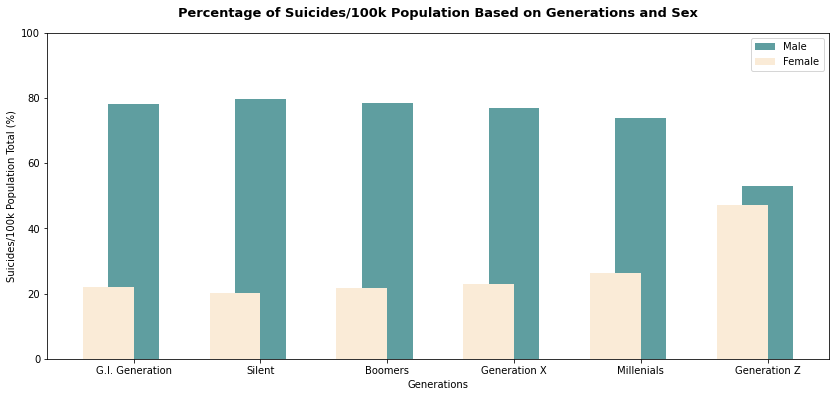

In [191]:
# Generations sex rank
temp = (pd.crosstab(index = data["generation"], columns = data["sex"], values = data["suicides/100k pop"], aggfunc = "sum", normalize = "index") * 100).reset_index()
temp.index = [2, 0, 3, 5, 4, 1]
temp.sort_index(inplace = True)

plt.figure(figsize = (14, 6))
plt.bar(temp.index, temp["male"], color = "cadetblue", width = 0.4)
plt.bar(temp.index - .2, temp["female"], color = "antiquewhite", width = 0.4)
plt.xticks(([x for x in temp.index]), ([y for y in temp["generation"]]))
plt.legend(("Male", "Female"))
plt.title(
        "Percentage of Suicides/100k Population Based on Generations and Sex", fontdict = {'fontsize': 13,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03
    )
plt.xlabel(
    "Generations",
    fontdict = {
        "size" : 10
    }
    )
plt.ylabel(
    "Suicides/100k Population Total (%)",
    fontdict = {
        "size" : 10
    }
    )
plt.ylim(0, 100)

plt.show()

Turns out generations took role in increasing number of suicides for female. Younger generation tends to produce more female suicide incidents. On the contrary, it tends to decrease male suicide rate.

## What about age then?

In [243]:
# Generations distribution based on suicides/100k pop
temp = round((pd.crosstab(index = data["age"], values = data["population"], columns = "% Population", aggfunc = "sum", normalize = "columns") * 100), 2).reset_index().rename(columns = {"age" : "Age Groups"})
temp.index = [1, 2, 3, 0, 4, 5]
temp.sort_index(inplace = True)
temp.columns.name = ""

print("Age groups distribution :")
display(temp.set_index("Age Groups"))

temp = round((pd.crosstab(index = data["age"], values = data["suicides/100k pop"], columns = "% Suicides/100k Pop", aggfunc = "sum", normalize = "columns") * 100), 2).reset_index().rename(columns = {"age" : "Age Groups"})
temp.index = [1, 2, 3, 0, 4, 5]
temp.sort_index(inplace = True)
temp.columns.name = ""

print("\nAge groups suicide/100k population distribution :")
display(temp.set_index("Age Groups"))

Age groups distribution :


,% Population
Age Groups,
5-14 years,16.61
15-24 years,16.96
25-34 years,16.52
35-54 years,27.87
55-74 years,16.79
75+ years,5.25



Age groups suicide/100k population distribution :


,% Suicides/100k Pop
Age Groups,
5-14 years,0.81
15-24 years,12.49
25-34 years,16.46
35-54 years,18.43
55-74 years,20.03
75+ years,31.78


Just the same as generation variable, the age groups population doesn't correlate with its suicide rate. Meanwhile, we found linear correlation between age itself and suicide rate. The older a person is, the higher his chance to commit suicide.

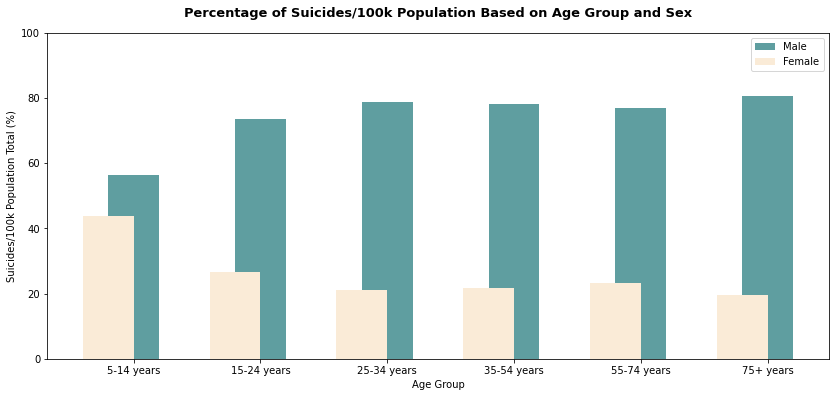

In [178]:
# Age group's sex rank
temp = (pd.crosstab(index = data["age"], columns = data["sex"], values = data["suicides/100k pop"], aggfunc = "sum", normalize = "index") * 100).reset_index()
temp.index = [1, 2, 3, 0, 4, 5]
temp.sort_index(inplace = True)

plt.figure(figsize = (14, 6))
plt.bar(temp.index, temp["male"], color = "cadetblue", width = 0.4)
plt.bar(temp.index - .2, temp["female"], color = "antiquewhite", width = 0.4)
plt.xticks(([x for x in temp.index]), ([y for y in temp["age"]]))
plt.legend(("Male", "Female"))
plt.title(
        "Percentage of Suicides/100k Population Based on Age Group and Sex", fontdict = {'fontsize': 13,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.03
    )
plt.xlabel(
    "Age Group",
    fontdict = {
        "size" : 10
    }
    )
plt.ylabel(
    "Suicides/100k Population Total (%)",
    fontdict = {
        "size" : 10
    }
    )
plt.ylim(0, 100)

plt.show()

We found a contradictory correlation in respect to generation variable. Age group on the other hand shows an increment for male, even though it's quite stagnant from 25 years to 75+ years old. Female population suicide rate on the other hand tend to decrease when they get older.

## Is it true prosperity correlate with suicide rate?

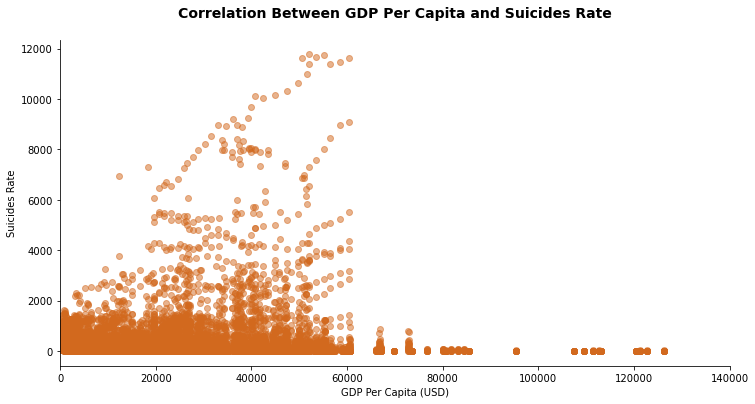

In [290]:
# gdp_per_capita and suicides_no
fig, ax = plt.subplots(figsize = (12, 6))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.scatter(x = data["gdp_per_capita"], y = data["suicides_no"], alpha = 0.5, c = "chocolate")
plt.title(
        "Correlation Between GDP Per Capita and Suicides Rate", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.05
    )
plt.ylabel(
    "Suicides Rate",
    fontdict = {
        "size" : 10
    }
    )
plt.xlabel(
    "GDP Per Capita (USD)",
    fontdict = {
        "size" : 10
    }
    )
plt.xlim(0, 140000)

plt.show()

Yes, prosperity does correlate with suicides number. We can conclude that the higher the GDP per capita is, the lower the suicide rate is. However, to be more specific, countries (within a year) whose have lowest GDP per capita tends to have lower suicide rate rather than the middle GDP per capita group (around 18.000 - 60.000 USD). We also see a sharp declining pattern, where GDP per capita above 70.000 USD has suicides rate bwlow 2.000 incidents. This means a more prosper country tends to have higher possibility to have lower suicide incident.

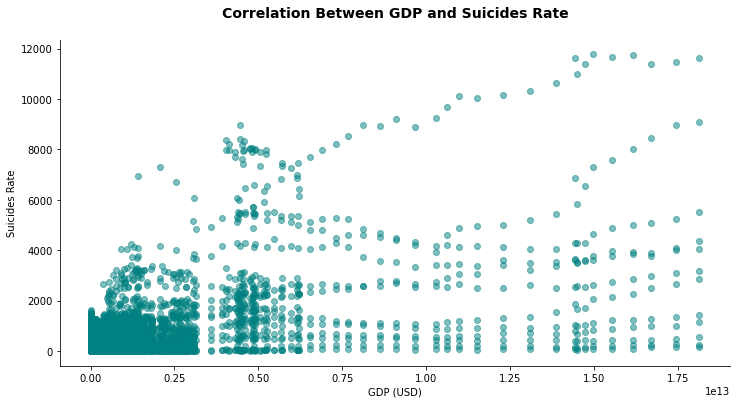

In [297]:
# gdp_for_year and suicides_no
fig, ax = plt.subplots(figsize = (12, 6))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.scatter(x = data["gdp_for_year"], y = data["suicides_no"], alpha = 0.5, c = "teal")
plt.title(
        "Correlation Between GDP and Suicides Rate", fontdict = {'fontsize': 14,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.05
    )
plt.ylabel(
    "Suicides Rate",
    fontdict = {
        "size" : 10
    }
    )
plt.xlabel(
    "GDP (USD)",
    fontdict = {
        "size" : 10
    }
    )

plt.show()

Meanwhile, GDP itself doesn't show us a quite clear pattern. This means population is important in determining correlation between national economy and suicide rate (because GDP per capita took population as concern).

## Which country does have the highest rate?

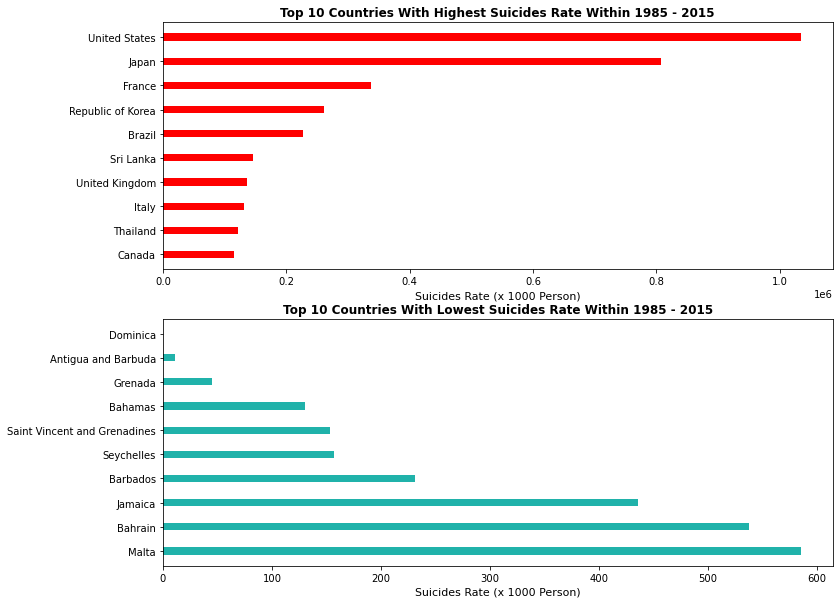

In [304]:
# Sucidies rate and countries
high = data.groupby("country").sum()[["suicides_no"]].sort_values("suicides_no", ascending = False).iloc[:10].sort_values("suicides_no")
low = data.groupby("country").sum()[["suicides_no"]].sort_values("suicides_no").iloc[:10].sort_values("suicides_no", ascending = False)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 10))
ax1.barh(high.index, high["suicides_no"],
       color = "red",
       height = 0.3,
       linewidth = 1
        )
ax1.set_title("Top 10 Countries With Highest Suicides Rate Within 1985 - 2015", fontdict = {'fontsize': 12,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1)
ax1.set_xlabel(
    "Suicides Rate (x 1000 Person)",
    fontdict = {
        "size" : 11
    }
    )

ax2.barh(low.index, low["suicides_no"],
       color = "lightseagreen",
       height = 0.3,
       linewidth = 1
        )
ax2.set_title("Top 10 Countries With Lowest Suicides Rate Within 1985 - 2015", fontdict = {'fontsize': 12,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1)
ax2.set_xlabel(
    "Suicides Rate (x 1000 Person)",
    fontdict = {
        "size" : 11
    }
    )

plt.show()

At glance US has the highest rate of suicides and Dominica has the lowest. It's very interesting to see Dominica has 0 suicide incident in 31 years. However, we mustn't put away population in respect to the rate itself. Considering population as an indicator is the best way to visualize how suicides rate vary across all countries. 

Now lets see if we plot it with _suicides/100k pop_ variale.

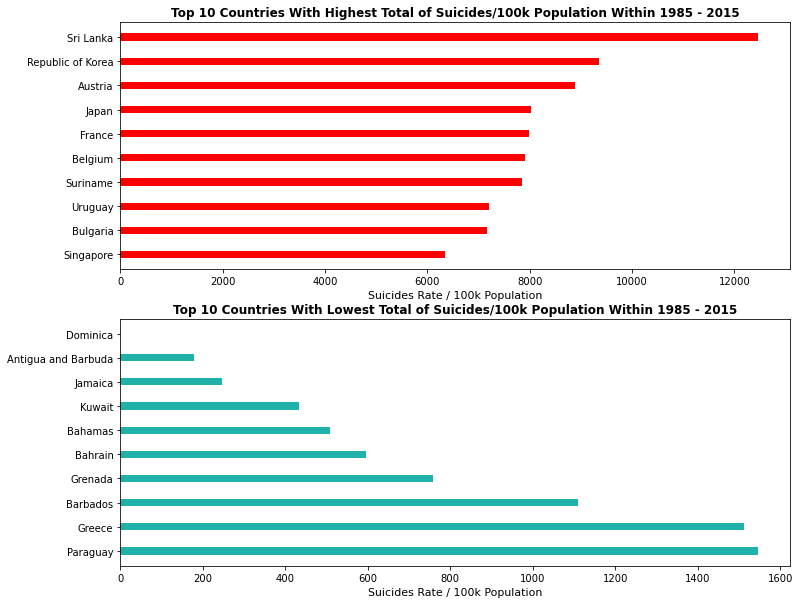

In [5]:
# sucidies/100k pop and countries
high_prop = data.groupby("country").sum()[["suicides/100k pop"]].sort_values("suicides/100k pop", ascending = False).iloc[:10].sort_values("suicides/100k pop")
low_prop = data.groupby("country").sum()[["suicides/100k pop"]].sort_values("suicides/100k pop").iloc[:10].sort_values("suicides/100k pop", ascending = False)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 10))
ax1.barh(high_prop.index, high_prop["suicides/100k pop"],
       color = "red",
       height = 0.3,
       linewidth = 1
        )
ax1.set_title("Top 10 Countries With Highest Total of Suicides/100k Population Within 1985 - 2015", fontdict = {'fontsize': 12,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1)
ax1.set_xlabel(
    "Suicides Rate / 100k Population",
    fontdict = {
        "size" : 11
    }
    )

ax2.barh(low_prop.index, low_prop["suicides/100k pop"],
       color = "lightseagreen",
       height = 0.3,
       linewidth = 1
        )
ax2.set_title("Top 10 Countries With Lowest Total of Suicides/100k Population Within 1985 - 2015", fontdict = {'fontsize': 12,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1)
ax2.set_xlabel(
    "Suicides Rate / 100k Population",
    fontdict = {
        "size" : 11
    }
    )

plt.show()

Now we know that, in respect to population size, US is not the highest country but Sri Lanka. Meanwhile, Dominica and Antigua and Barbuda are still the lowest.

## What can we learn from the top 10?

**Top 10 Highest**

Red bar indicates group with highest suicides rate



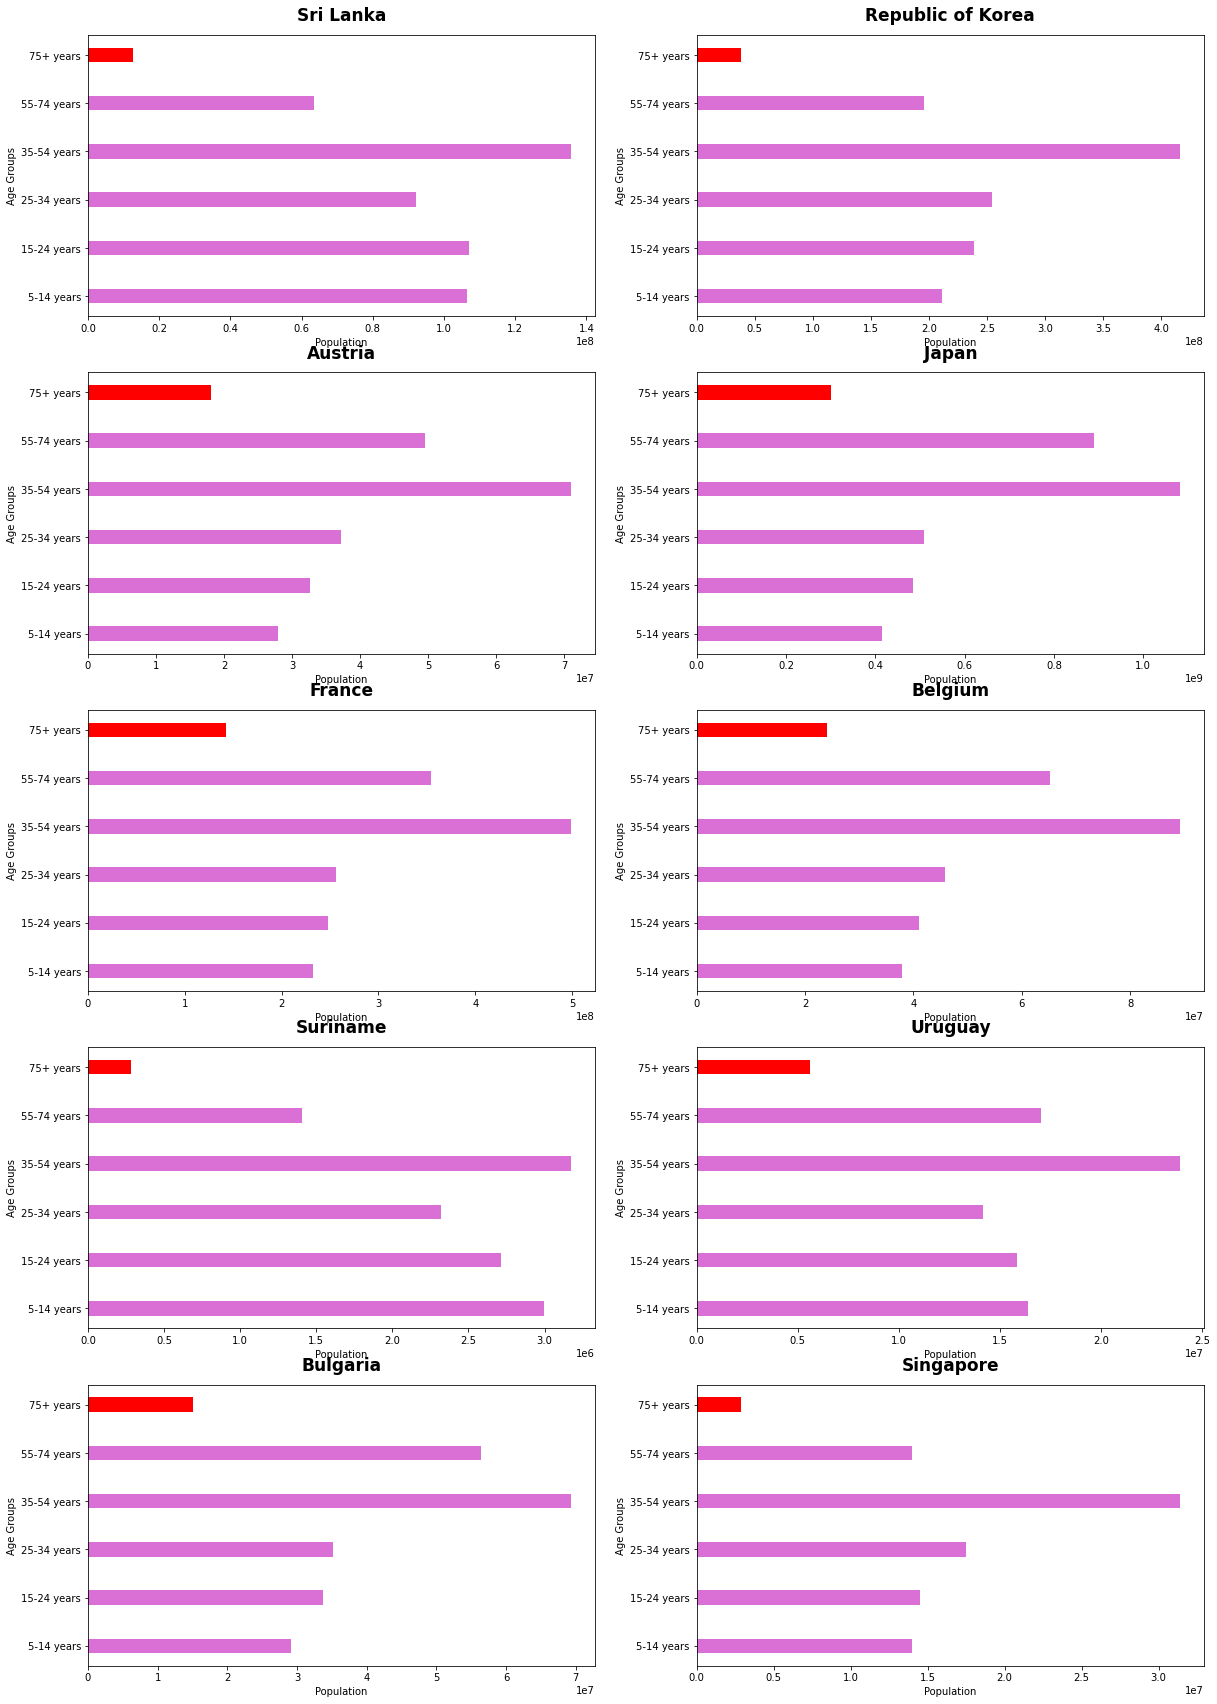

In [131]:
# Age group distribution
row, col = 0, 0
print("Red bar indicates group with highest suicides rate\n")

fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (20, 30))
for x in high_prop.sort_values("suicides/100k pop", ascending = False).index: 
    if col > 1:
        col = 0
        row += 1
    
    temp = data[data["country"] == x].groupby("age").sum()[["population", "suicides/100k pop"]].reset_index()
    temp.index = [1, 2, 3, 0, 4, 5]
    temp.sort_index(inplace = True)
    
    ax[row][col].barh(temp["age"], width = temp["population"], height = 0.3, color = ["orchid" if x != temp["suicides/100k pop"].idxmax() else "red" for x in temp.index])
    ax[row][col].set_title(
    f"{x}", fontdict = {'fontsize': 17,
    'fontweight' : "bold",
    'color' : "black",
    'verticalalignment': 'baseline',
    'horizontalalignment': "center"
    }, y = 1.03)
    ax[row][col].set_xlabel(
        "Population",
        fontdict = {
            "size" : 10
        }
        )
    ax[row][col].set_ylabel(
        "Age Groups",
        fontdict = {
            "size" : 10
        }
        )
    
    col += 1

Turns out these countries have a common pattern, which is having middle age group as the highest population. Also note that almost all of them have 55-74 years group as the second highest. This means they are inhabited by majority of middle age and elders. However, the oldest group, which is the lowest population, has the highest suicides rate across all countries.

Red bar indicates group with highest suicides rate



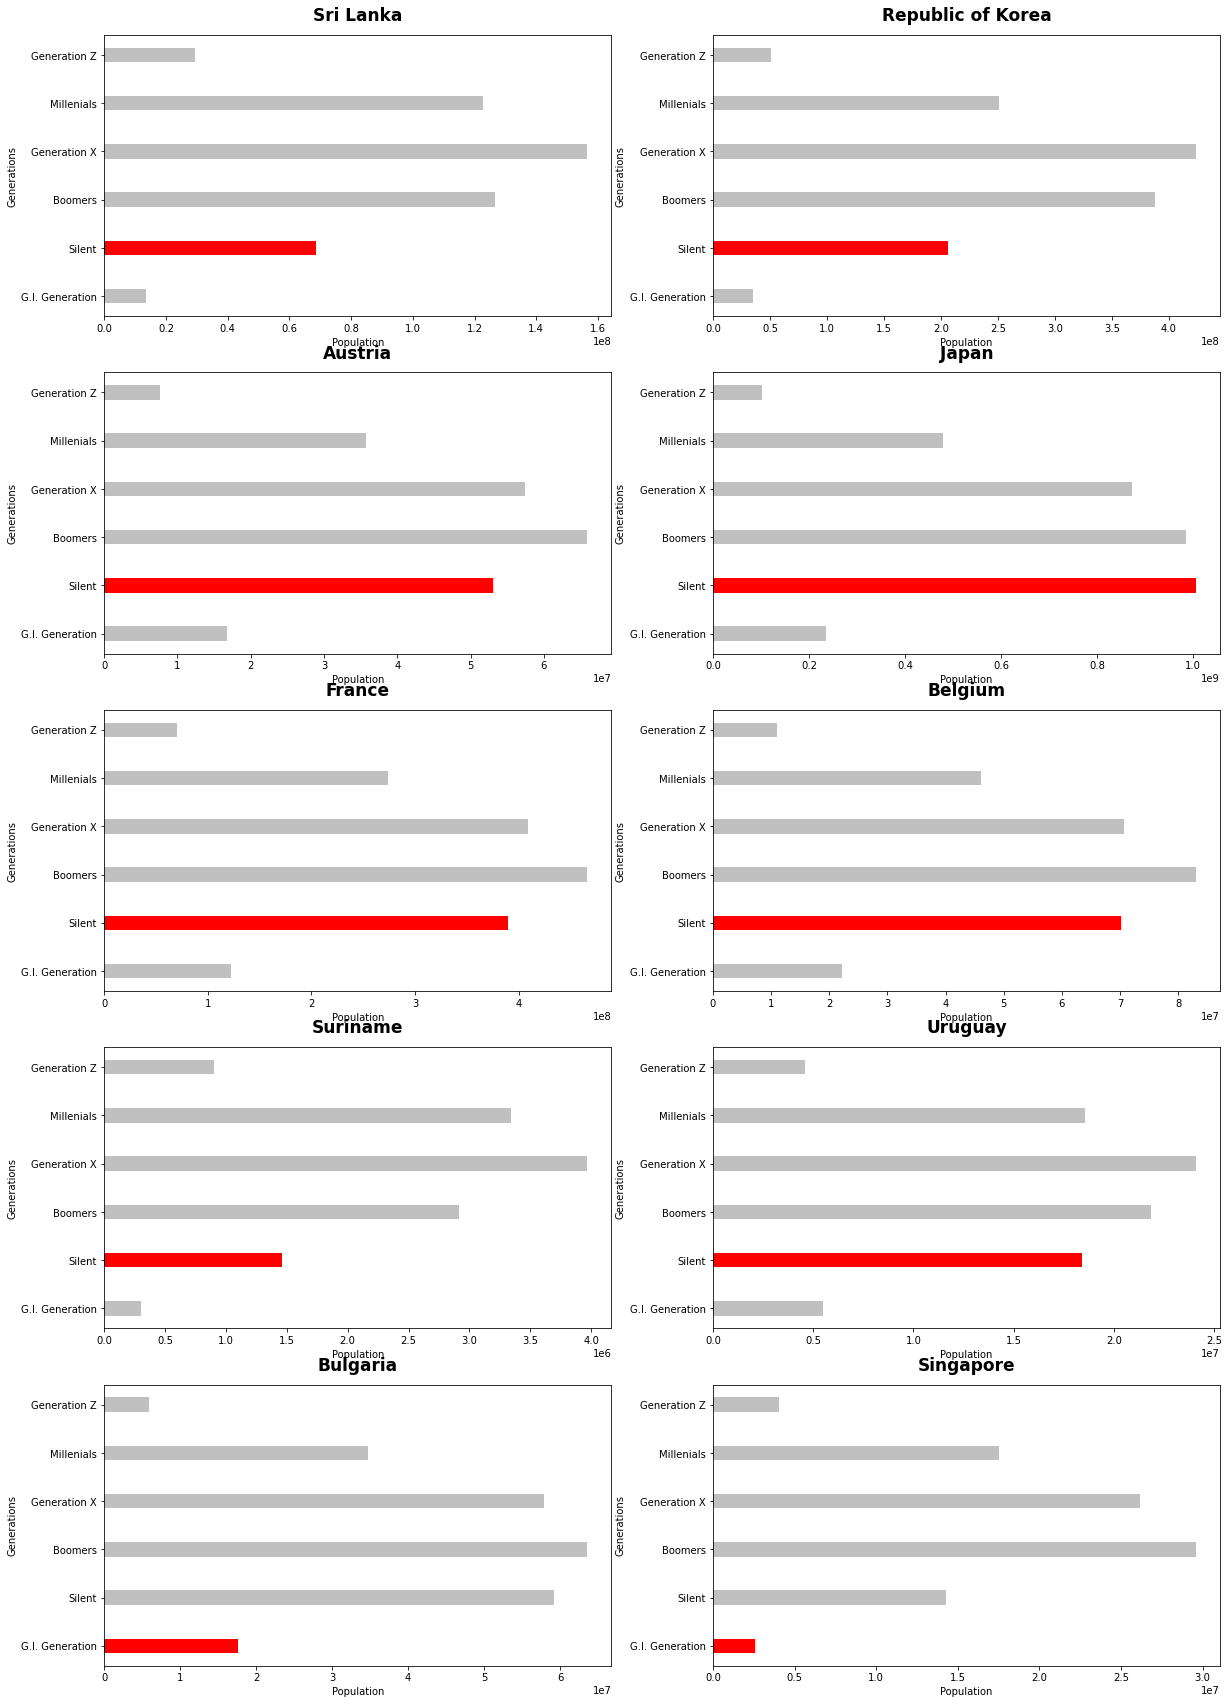

In [86]:
# Generations distribution
row, col = 0, 0
print("Red bar indicates group with highest suicides rate\n")

fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (20, 30))
for x in high_prop.sort_values("suicides/100k pop", ascending = False).index: 
    if col > 1:
        col = 0
        row += 1
    
    temp = data[data["country"] == x].groupby("generation").sum()[["population", "suicides/100k pop"]].reset_index()
    temp.index = [2, 0, 3, 5, 4, 1]
    temp.sort_index(inplace = True)
    
    ax[row][col].barh(temp["generation"], width = temp["population"], height = 0.3, color = ["silver" if x != temp["suicides/100k pop"].idxmax() else "red" for x in temp.index])
    ax[row][col].set_title(
    f"{x}", fontdict = {'fontsize': 17,
    'fontweight' : "bold",
    'color' : "black",
    'verticalalignment': 'baseline',
    'horizontalalignment': "center"
    }, y = 1.03)
    ax[row][col].set_xlabel(
        "Population",
        fontdict = {
            "size" : 10
        }
        )
    ax[row][col].set_ylabel(
        "Generations",
        fontdict = {
            "size" : 10
        }
        )
    
    col += 1

Old generations (Generation X and Boomers) dominate the countries. Meanwhile, the highest suicide incidents occurs on the oldest generation. It means the 75 years old above in 2000s give the most contribution to suicides rate for these countries.

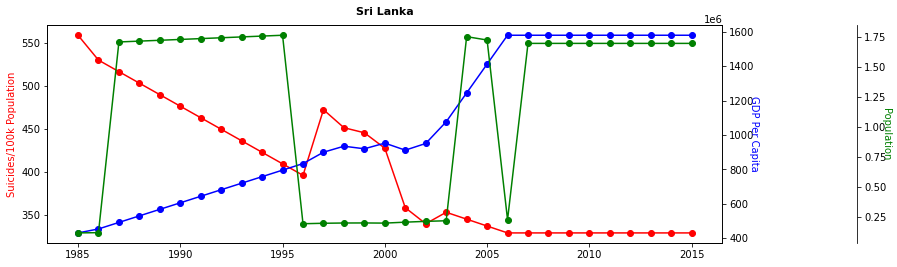

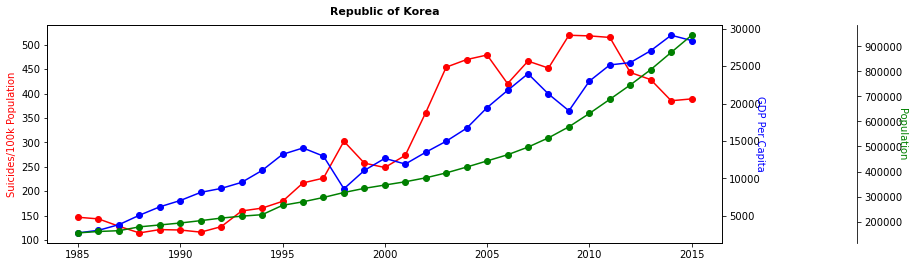

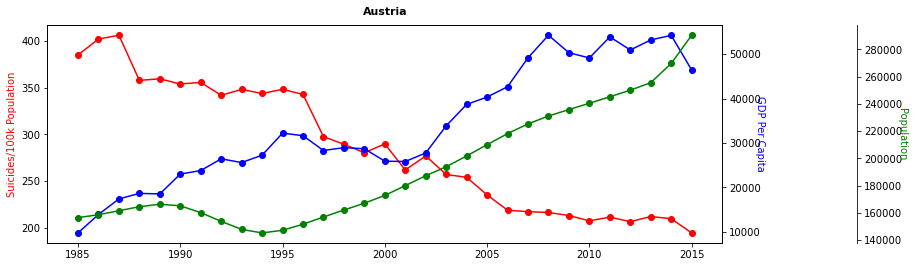

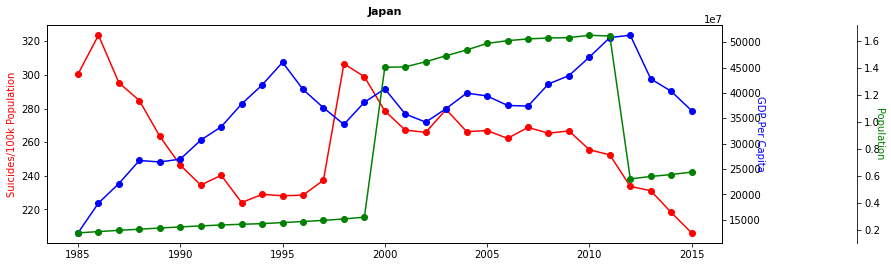

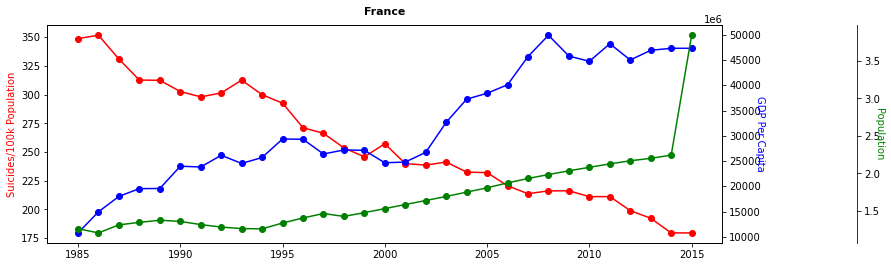

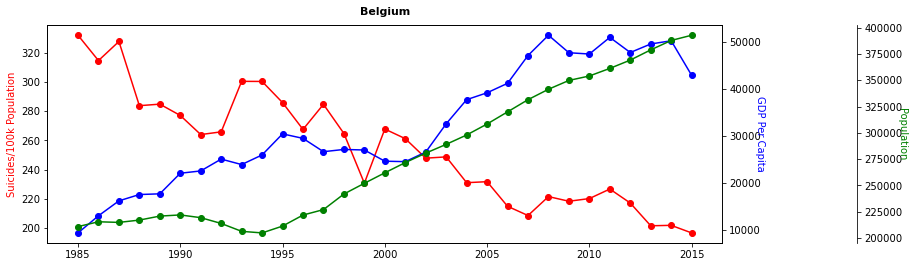

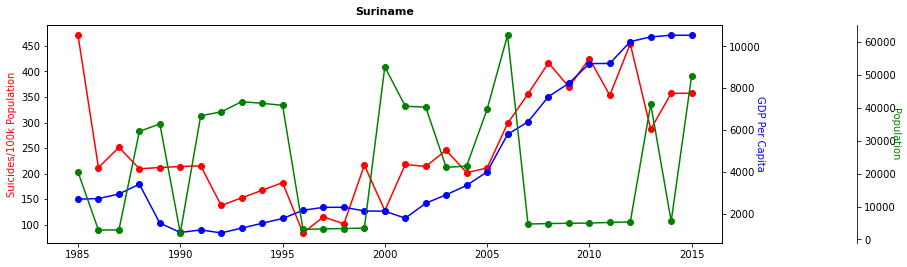

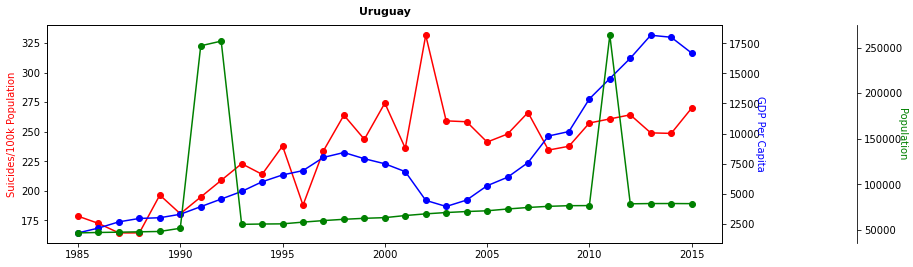

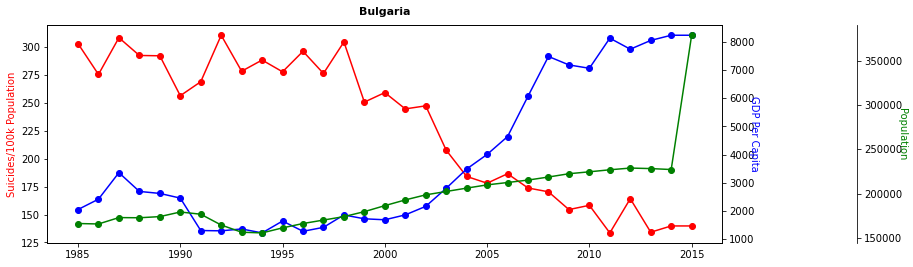

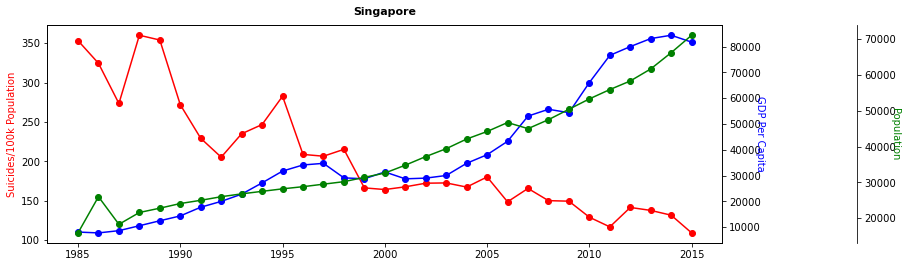

In [133]:
# 10 highest countries based on their suiceds/100k pop and GDP per capita
for x in high_prop.sort_values("suicides/100k pop", ascending = False).index:
    fig, ax = plt.subplots(figsize = (15, 4))
    fig.subplots_adjust(right = 0.75)


    temp = data[data["country"] == x]
    temp_ = temp.groupby("year").sum()[["suicides/100k pop"]]
    temp_["gdp_per_capita"] = temp.drop_duplicates("year").sort_values("year")["gdp_per_capita"].values
    temp_["population"] = temp.drop_duplicates("year").sort_values("year")["population"].values

    ax.plot(temp_.index, temp_["suicides/100k pop"], color = "red", marker = "o")
    ax.set_ylabel(
        "Suicides/100k Population",
        color = "red",
        fontsize = 10)

    ax2 = ax.twinx()
    ax2.plot(temp_.index, temp_["gdp_per_capita"], color = "blue", marker = "o")
    ax2.set_ylabel(
        "GDP Per Capita",
        color = "blue",
        fontsize = 10,
        rotation = 270)

    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    ax3.spines["right"].set_visible(True)
    ax3.plot(temp_.index, temp_["population"], color = "green", marker = "o")
    ax3.set_ylabel(
        "Population",
        color = "green",
        fontsize = 10,
        rotation = 270)

    ax.set_title(
        f"{x}", fontdict = {'fontsize': 11,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.02)
    
    plt.show()

From the graph above we know that a positive correlation between GDP per capita and population tend to followed by drops of suicide rate. Otherwise, if these two negatively correlate, suicides rate tend to increase. GDP per capita itself has stronger correlation rather than population, where we can see high increment of population doesn't instantly decrease suicide rate.

**Top 10 Lowest**

Red bar indicates group with highest suicides rate



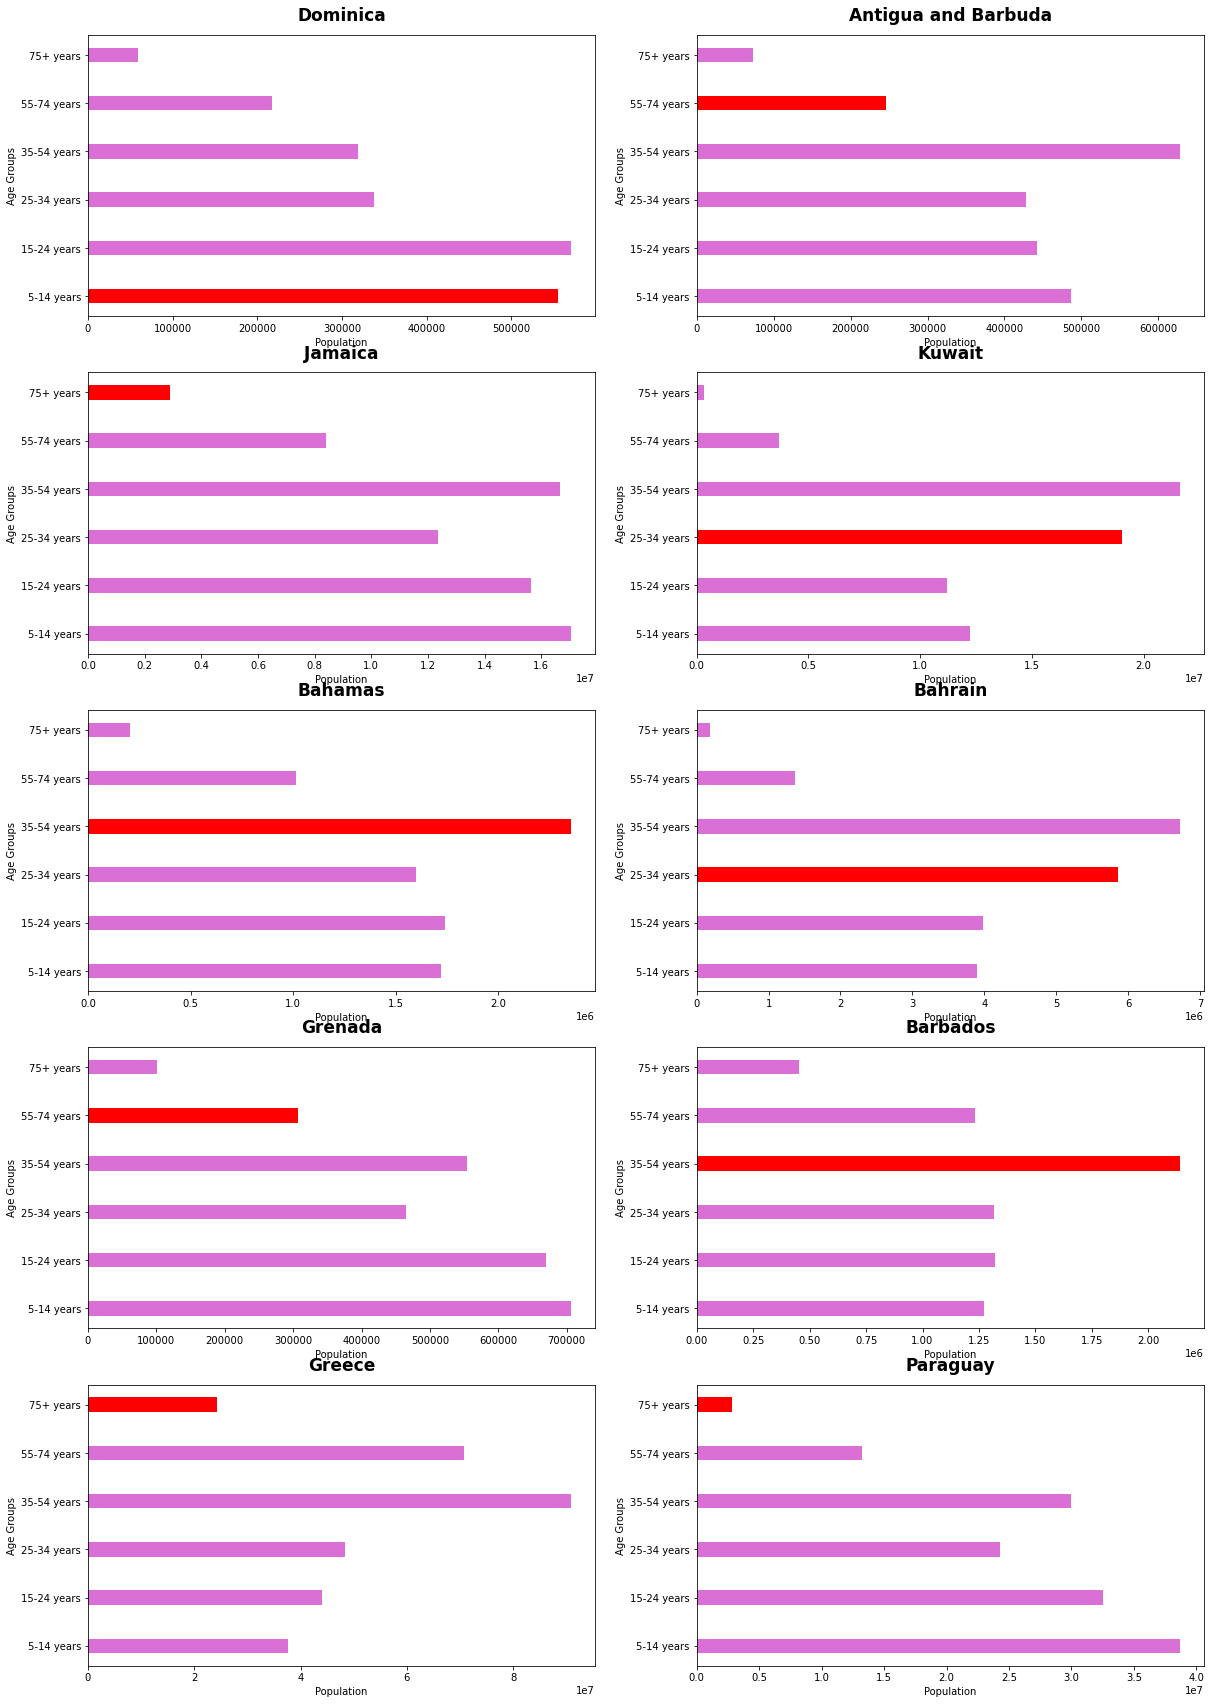

In [134]:
# Age group distribution
row, col = 0, 0
print("Red bar indicates group with highest suicides rate\n")

fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (20, 30))
for x in low_prop.sort_values("suicides/100k pop").index: 
    if col > 1:
        col = 0
        row += 1
    
    temp = data[data["country"] == x].groupby("age").sum()[["population", "suicides/100k pop"]].reset_index()
    temp.index = [1, 2, 3, 0, 4, 5]
    temp.sort_index(inplace = True)
    
    ax[row][col].barh(temp["age"], width = temp["population"], height = 0.3, color = ["orchid" if x != temp["suicides/100k pop"].idxmax() else "red" for x in temp.index])
    ax[row][col].set_title(
    f"{x}", fontdict = {'fontsize': 17,
    'fontweight' : "bold",
    'color' : "black",
    'verticalalignment': 'baseline',
    'horizontalalignment': "center"
    }, y = 1.03)
    ax[row][col].set_xlabel(
        "Population",
        fontdict = {
            "size" : 10
        }
        )
    ax[row][col].set_ylabel(
        "Age Groups",
        fontdict = {
            "size" : 10
        }
        )
    
    col += 1

We can see an obvious difference here between the top 10 highest countries. The lowest countries group tends to have younger population rather than the elders. Even if a middle age group appears as the highest (Barbados), the rest of the groups seem equal, not like top 10 highest countries which tend to have 55-74 years old group as the second highest. The suicide rate also differ, where this group doesn't have 75+ years old group as the highest for all countries. Dominica even has the youngest group as the most contributed group for suicide rate.

Red bar indicates group with highest suicides rate



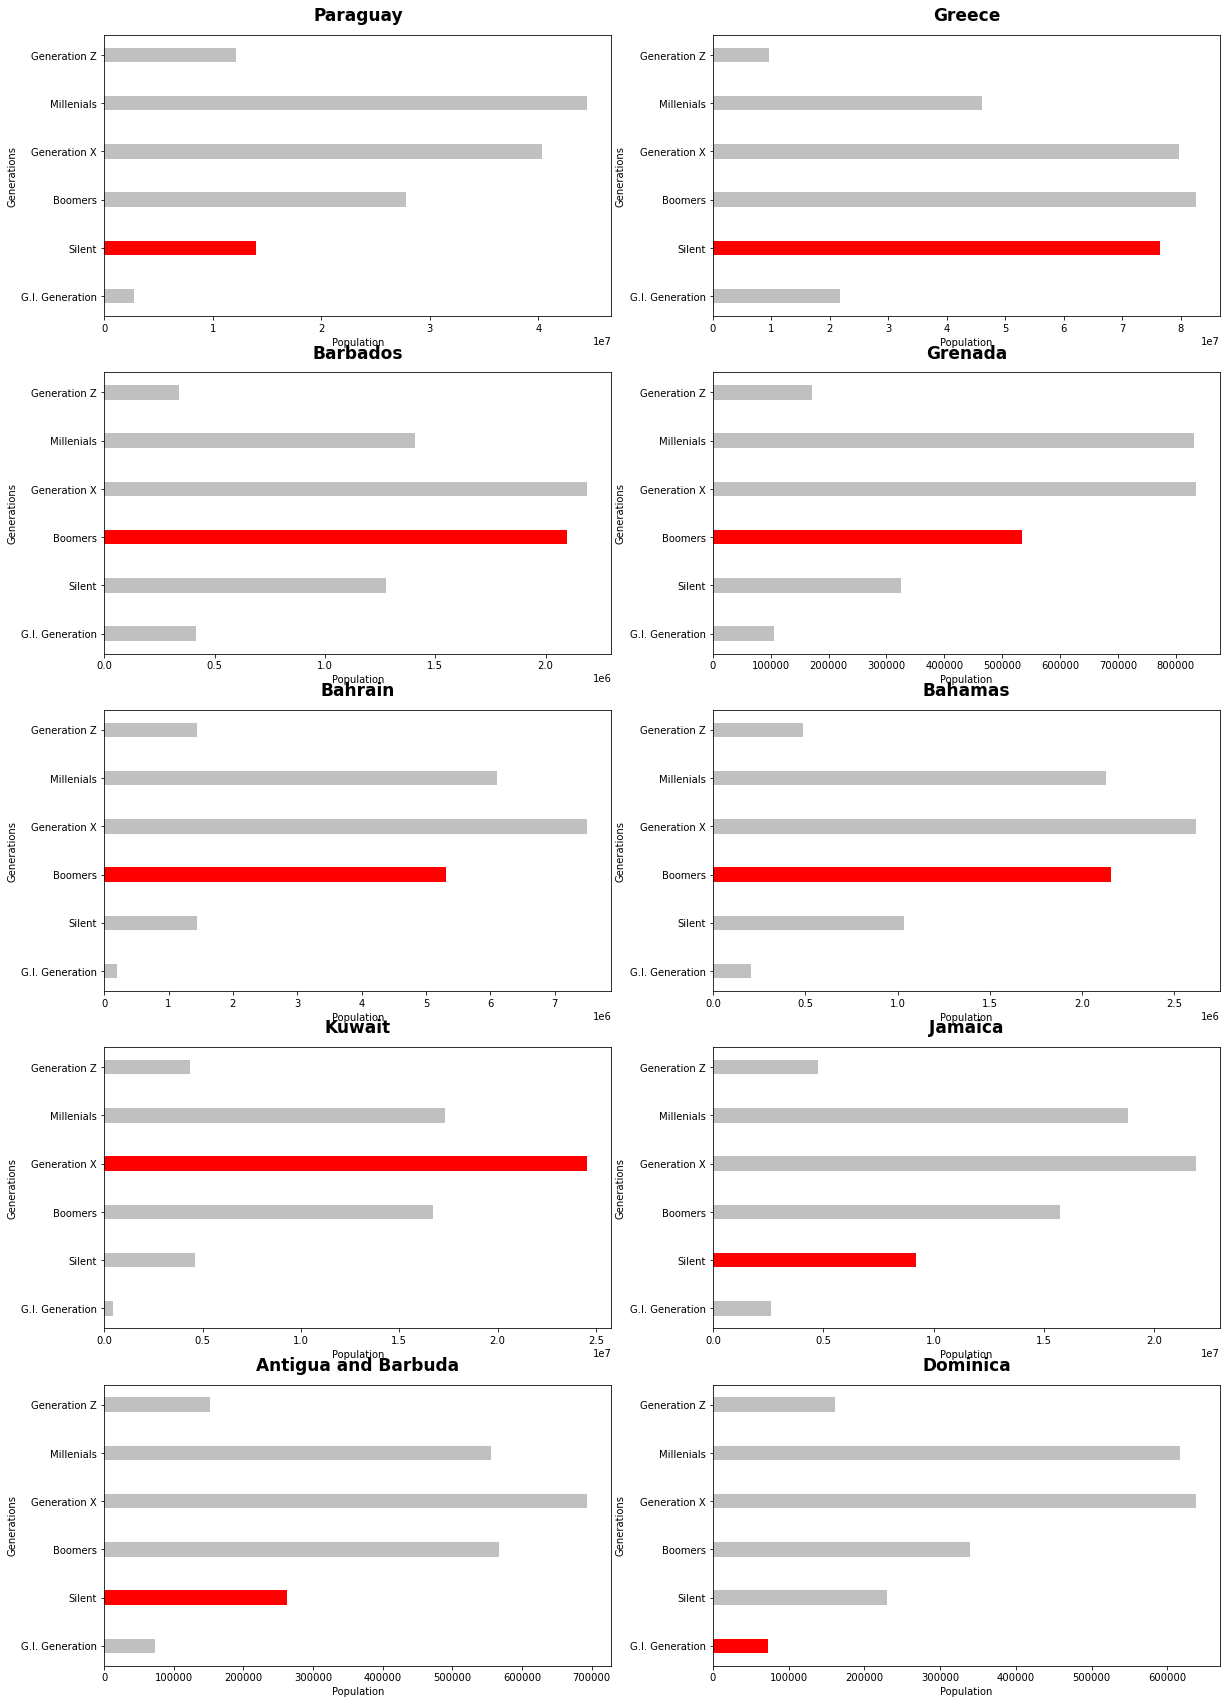

In [135]:
# Generations distribution
row, col = 0, 0
print("Red bar indicates group with highest suicides rate\n")

fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (20, 30))
for x in low_prop.sort_values("suicides/100k pop", ascending = False).index: 
    if col > 1:
        col = 0
        row += 1
    
    temp = data[data["country"] == x].groupby("generation").sum()[["population", "suicides/100k pop"]].reset_index()
    temp.index = [2, 0, 3, 5, 4, 1]
    temp.sort_index(inplace = True)
    
    ax[row][col].barh(temp["generation"], width = temp["population"], height = 0.3, color = ["silver" if x != temp["suicides/100k pop"].idxmax() else "red" for x in temp.index])
    ax[row][col].set_title(
    f"{x}", fontdict = {'fontsize': 17,
    'fontweight' : "bold",
    'color' : "black",
    'verticalalignment': 'baseline',
    'horizontalalignment': "center"
    }, y = 1.03)
    ax[row][col].set_xlabel(
        "Population",
        fontdict = {
            "size" : 10
        }
        )
    ax[row][col].set_ylabel(
        "Generations",
        fontdict = {
            "size" : 10
        }
        )
    
    col += 1

There's only small difference when we're talking about generations. Paraguay suppresses Generation X number with its millenials, meanwhile millenials in Grenada and Dominica compete with Generation X. The rest of them seem have quite same pattern with top 10 highest countries. Also, suicides rate tends to be younger in this group. Generation X even become the highest for some countries.

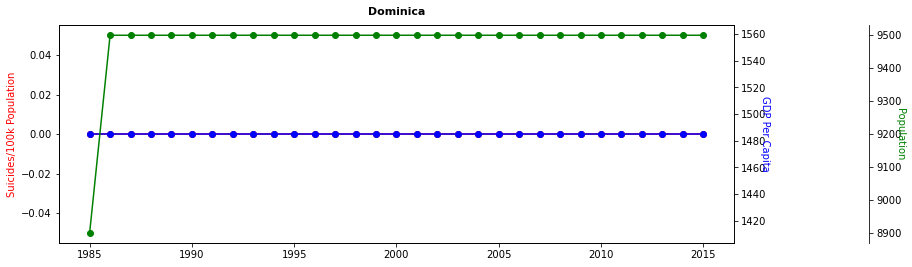

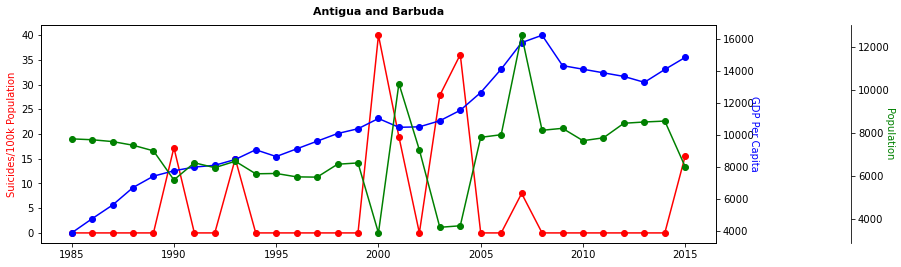

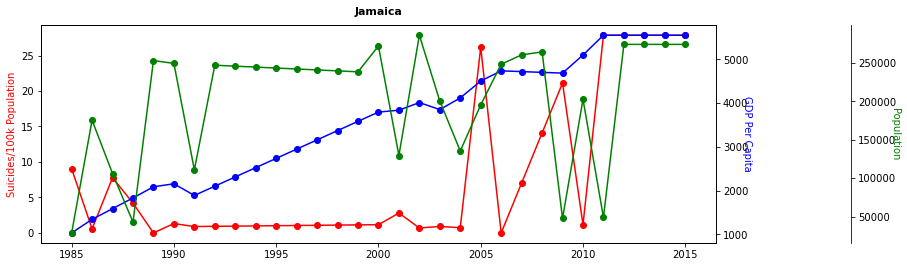

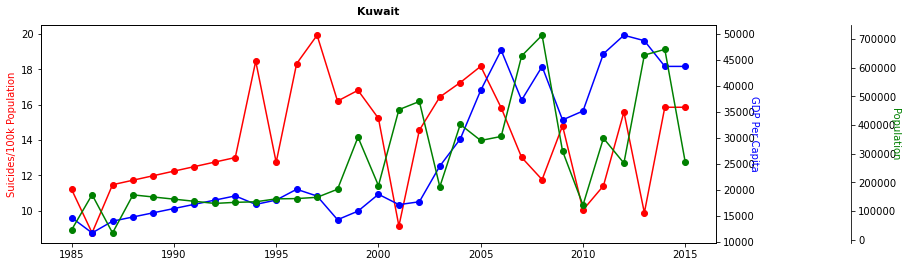

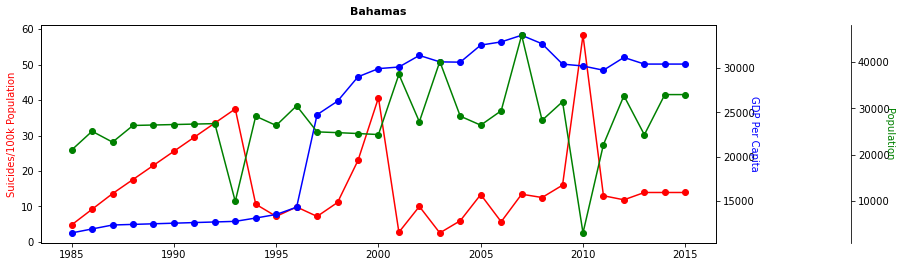

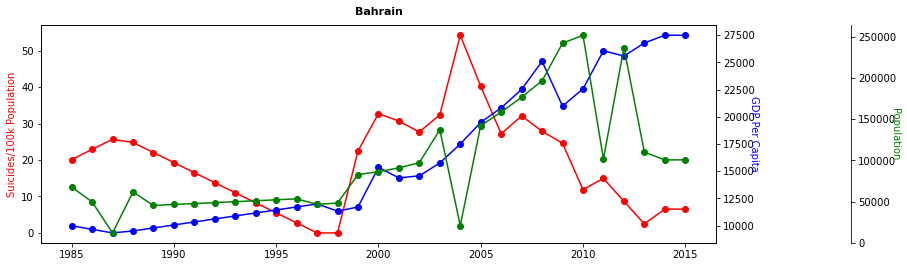

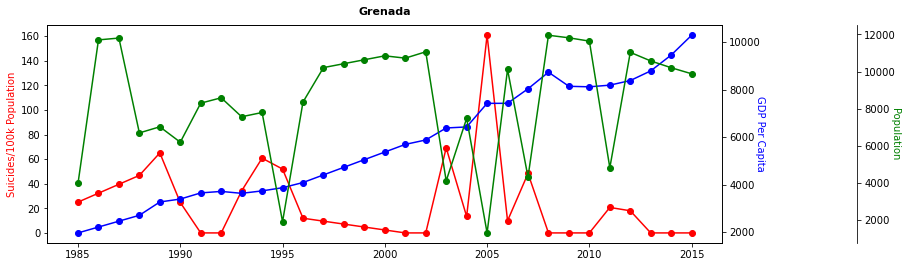

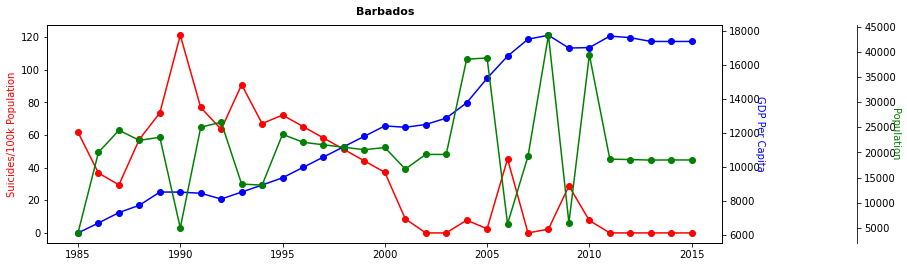

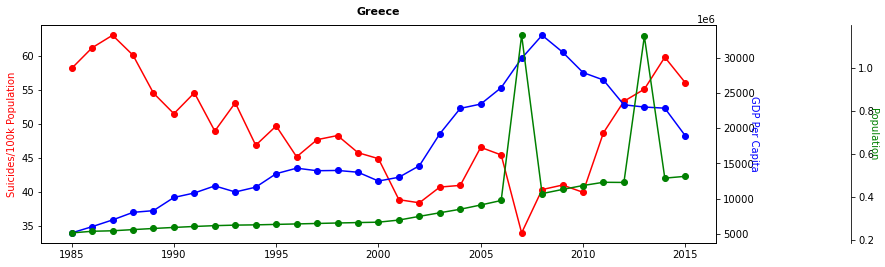

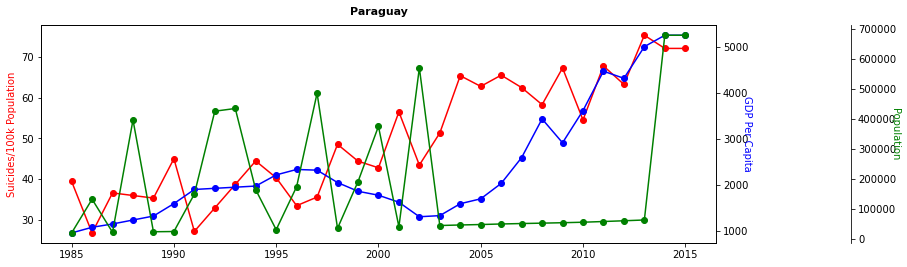

In [136]:
# 10 lowest countries based on their suiceds/100k pop and GDP per capita
for x in low_prop.sort_values("suicides/100k pop").index:
    fig, ax = plt.subplots(figsize = (15, 4))
    fig.subplots_adjust(right = 0.75)


    temp = data[data["country"] == x]
    temp_ = temp.groupby("year").sum()[["suicides/100k pop"]]
    temp_["gdp_per_capita"] = temp.drop_duplicates("year").sort_values("year")["gdp_per_capita"].values
    temp_["population"] = temp.drop_duplicates("year").sort_values("year")["population"].values

    ax.plot(temp_.index, temp_["suicides/100k pop"], color = "red", marker = "o")
    ax.set_ylabel(
        "Suicides/100k Population",
        color = "red",
        fontsize = 10)

    ax2 = ax.twinx()
    ax2.plot(temp_.index, temp_["gdp_per_capita"], color = "blue", marker = "o")
    ax2.set_ylabel(
        "GDP Per Capita",
        color = "blue",
        fontsize = 10,
        rotation = 270)

    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    ax3.spines["right"].set_visible(True)
    ax3.plot(temp_.index, temp_["population"], color = "green", marker = "o")
    ax3.set_ylabel(
        "Population",
        color = "green",
        fontsize = 10,
        rotation = 270)

    ax.set_title(
        f"{x}", fontdict = {'fontsize': 11,
        'fontweight' : "bold",
        'color' : "black",
        'verticalalignment': 'baseline',
        'horizontalalignment': "center"
        }, y = 1.02)
    
    plt.show()

Pattern in this group seems more fuzzy than the top 10 highest group. It's quite interesting that for the top lowest countries GDP per capita seems not so impactful. We can see especially from Antigua and Barbuda, Jamaica, Kuwait, Bahrain, Grenada that in some years increment of GDP per capita followed by increment of suicide rate. Population seems quite better correlate with suicide rate, which shows a negative correlation.